# LeNet Traffic Sign Classifier for GTSRB Datasets

---
## Step 0: Load The Data

In [1]:
# Dependencies
import pickle
import matplotlib.pyplot as plt
from Traffic_Sign_Classification.helper_functions import data_processing as dp
import numpy as np
from sklearn.utils import shuffle
import os

In [2]:
# Load pickled data

training_file = "./datasets/normalized_data/train.p"
validation_file = "./datasets/normalized_data/valid.p"
testing_file = "./datasets/normalized_data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print("Successfully loaded the data!")

Successfully loaded the data!


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [6]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:3]

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file.


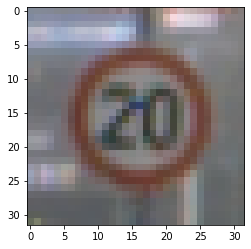

In [7]:
%matplotlib inline

plt.imshow(X_train[10000])

----

## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set (normalization, grayscale, etc.)

#### 1. Turn the data set into greyscale

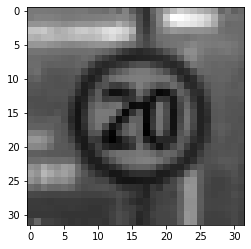

In [8]:
# dp.img_array_rgb2gray(X_train[10000])
X_test_grey = []
for i in range(X_test.shape[0]):
    X_test_grey.append(dp.img_array_rgb2gray(X_test[i]))
X_test_grey = np.array(X_test_grey)

X_train_grey = []
for i in range(X_train.shape[0]):
    X_train_grey.append(dp.img_array_rgb2gray(X_train[i]))
X_train_grey = np.array(X_train_grey).astype("float32")

X_valid_grey = []
for i in range(X_valid.shape[0]):
    X_valid_grey.append(dp.img_array_rgb2gray(X_valid[i]))
X_valid_grey = np.array(X_valid_grey)

plt.imshow(X_train_grey[10000], cmap="gray")

#### 2. Shuffle the data and add a dimension to X_train

In [9]:
X_train_grey = X_train_grey[:, :, :, np.newaxis]
X_valid_grey = X_valid_grey[:, :, :, np.newaxis]
X_test_grey = X_test_grey[:, :, :, np.newaxis]
X_train_grey, y_train = shuffle(X_train_grey, y_train)

### Model Architecture

#### 1. The Tensorflow Model

In [10]:
from Traffic_Sign_Classification.lenet_structure import *

### Train, Validate and Test the Model

#### 0. Whether to start a new training session

In [12]:
new_train = True
saved_file_prefix = "./lenet_tf_ckpts/lenet"

#### 1. Build the tensorflow optimizer

In [13]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

tf_logits = lenet_tf(x, keep_prob)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=tf_logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate_dacayed)
training_operation = optimizer.minimize(loss_operation, global_step=global_step)


Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



#### 2. Build the tensorflow evaluator

In [14]:
correct_prediction = tf.equal(tf.argmax(tf_logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#### 3. Train the Model

In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    if new_train:
        list_training_accuracy = [0]
        list_validation_accuracy = [0]
        stabled_times = 0

        print("Training...")
        for i in range(EPOCHS):
            X_train_grey, y_train = shuffle(X_train_grey, y_train)
            for offset in range(0, n_train, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train_grey[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:drop_out_rate})

            list_validation_accuracy.append(evaluate(X_valid_grey, y_valid))
            list_training_accuracy.append(evaluate(X_train_grey, y_train))
            print("EPOCH {} ...".format(i+1))
            if i % 5 == 0:
                print("Validation Accuracy = {:.3f}".format(list_validation_accuracy[-1]), "Training Accuracy = {:.3f}".format(list_training_accuracy[-1]))
                print()

            if abs(list_validation_accuracy[-1] - list_validation_accuracy[-2]) <= stable_gap:
                stabled_times += 1
            else:
                stabled_times = 0

            if stabled_times >= quit_stabled_times:
                break

        saver.save(sess, saved_file_prefix)
        print("Model saved. Final Result:")
        print("Validation Accuracy = {:.3f}".format(list_validation_accuracy[-1]), "Training Accuracy = {:.3f}".format(list_training_accuracy[-1]))

Training...
EPOCH 1 ...
Validation Accuracy = 0.395 Training Accuracy = 0.427

EPOCH 2 ...
EPOCH 3 ...
EPOCH 4 ...
EPOCH 5 ...
EPOCH 6 ...
Validation Accuracy = 0.854 Training Accuracy = 0.916

EPOCH 7 ...
EPOCH 8 ...
EPOCH 9 ...
EPOCH 10 ...
EPOCH 11 ...
Validation Accuracy = 0.909 Training Accuracy = 0.965

EPOCH 12 ...
EPOCH 13 ...
EPOCH 14 ...
EPOCH 15 ...
EPOCH 16 ...
Validation Accuracy = 0.924 Training Accuracy = 0.981

EPOCH 17 ...
EPOCH 18 ...
EPOCH 19 ...
EPOCH 20 ...
EPOCH 21 ...
Validation Accuracy = 0.928 Training Accuracy = 0.987

EPOCH 22 ...
EPOCH 23 ...
EPOCH 24 ...
EPOCH 25 ...
EPOCH 26 ...
Validation Accuracy = 0.937 Training Accuracy = 0.989

EPOCH 27 ...
EPOCH 28 ...
EPOCH 29 ...
EPOCH 30 ...
EPOCH 31 ...
Validation Accuracy = 0.942 Training Accuracy = 0.992

EPOCH 32 ...
EPOCH 33 ...
EPOCH 34 ...
EPOCH 35 ...
EPOCH 36 ...
Validation Accuracy = 0.937 Training Accuracy = 0.994

EPOCH 37 ...
EPOCH 38 ...
EPOCH 39 ...
EPOCH 40 ...
EPOCH 41 ...
Validation Accuracy = 0.

#### 4. Evaluate the Model

In [19]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint("./lenet_tf_ckpts"))

    test_accuracy = evaluate(X_test_grey, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet_tf_ckpts/lenet
Test Accuracy = 0.925


#### 5. Draw the Training Curve

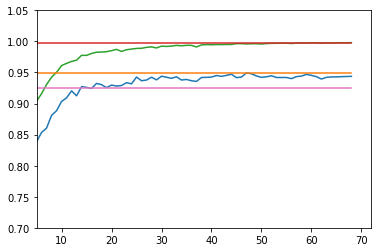

In [20]:
### Uncomment the following code for a new round of training
if new_train:
    xdata = np.arange(i + 2)
    y_upper = np.ones(i + 2) * np.max(list_training_accuracy)
    y_valid_upper = np.ones(i + 2) * np.max(list_validation_accuracy)
    y_test_upper = np.ones(i + 2) * test_accuracy

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(xdata, np.array(list_validation_accuracy), color='tab:blue')
    ax.plot(xdata, np.array(list_training_accuracy), color='tab:green')
    ax.plot(xdata, y_upper, color='tab:red')
    ax.plot(xdata, y_valid_upper, color='tab:orange')
    ax.plot(xdata, y_test_upper, color='tab:pink')

    ax.set_xlim([5,i+5])
    ax.set_ylim([0.7, 1.05])

    fig.savefig("./references/results/training_curve.jpg")

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

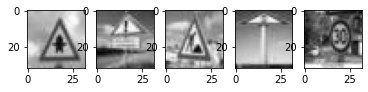

In [21]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
root_dir = "./references/test_image/normalized/"

accurate_pred = np.array([11, 18, 25, 26, 1])

fig = plt.figure(1)
subplot_index = 151
img_list = []
for filename in sorted(os.listdir(root_dir)):
    plt.subplot(subplot_index)
    img_list.append(plt.imread(root_dir+filename))
    plt.imshow(img_list[-1], cmap="gray")
    subplot_index += 1

### Predict the Sign Type for Each Image

In [23]:
# Form an nx32x32x1 nparray as input.
input_img_arr = np.array(img_list, dtype=np.int32)
input_img_arr = input_img_arr[:, :, :, np.newaxis]

tf_softmax = tf.nn.softmax(tf_logits)

# Feed the input into the model
with tf.compat.v1.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./lenet_tf_ckpts'))
    logits_predicted = sess.run(tf_logits, feed_dict={x:input_img_arr, keep_prob:1})
    softmax_predicted = sess.run(tf_softmax, feed_dict={x:input_img_arr, keep_prob:1})

# Print the result logits

prediction = np.argmax(softmax_predicted, axis=1)
# print(softmax_pricted)
print("The predicted classes for 5 new images are:\n", prediction)

INFO:tensorflow:Restoring parameters from ./lenet_tf_ckpts/lenet
The predicted classes for 5 new images are:
 [11 26 25 36 25]


### Analyze Performance

In [24]:
### Calculate the accuracy for these 5 new images.
accuracy_5_img = np.sum(prediction==accurate_pred)

print("The accuracy in predicting the 5 new images is:", 100 * accuracy_5_img/accurate_pred.size, "%")

The accuracy in predicting the 5 new images is: 40.0 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [25]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
with tf.compat.v1.Session() as sess:
    top_values = sess.run(tf.nn.top_k(tf.constant(softmax_predicted), k=5))

top_5_softmax = np.round(top_values.values, decimals=3)

top_5_indices = top_values.indices

for i in range(5):
    print("For image ", i, ", the top 5 softmax values are:\n", top_5_softmax[i])
    print("With the corresponding indices:\n", top_5_indices[i], '\n')


For image  0 , the top 5 softmax values are:
 [1. 0. 0. 0. 0.]
With the corresponding indices:
 [11 30 21 27 24] 

For image  1 , the top 5 softmax values are:
 [0.186 0.135 0.135 0.109 0.084]
With the corresponding indices:
 [26 31 14 39 33] 

For image  2 , the top 5 softmax values are:
 [1. 0. 0. 0. 0.]
With the corresponding indices:
 [25 26 30 20 24] 

For image  3 , the top 5 softmax values are:
 [0.494 0.465 0.023 0.008 0.007]
With the corresponding indices:
 [36 35 33 13 12] 

For image  4 , the top 5 softmax values are:
 [1. 0. 0. 0. 0.]
With the corresponding indices:
 [25 12 13  3 36] 

